In [2]:
import warnings
import itertools

import pandas as pd
import numpy as np

from pandas.plotting import autocorrelation_plot

import matplotlib.pyplot as plt
from pylab import rcParams

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import statsmodels

from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm

%config Completer.use_jedi = False

In [3]:
data = sm.datasets.co2.load_pandas()
y = data.data

### Data

### Resampling data to change the time frame

In [5]:
# The 'MS' string groups the data in buckets by start of the month
yMonthly = y[['co2']].resample('MS').mean()

### Fill nulls with the previous value

In [6]:
# The term bfill means that we use the value before filling in missing values
yMonthly.fillna(method='bfill', inplace=True)

In [7]:
yMonthly


,co2
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,315.625000
1958-07-01,315.625000
...,...
2001-08-01,369.425000
2001-09-01,367.880000
2001-10-01,368.050000
2001-11-01,369.375000


### Visualizing the time series

In [8]:
yMonthly.head()

,co2
1958-03-01,316.100000
1958-04-01,317.200000
1958-05-01,317.433333
1958-06-01,315.625000
1958-07-01,315.625000


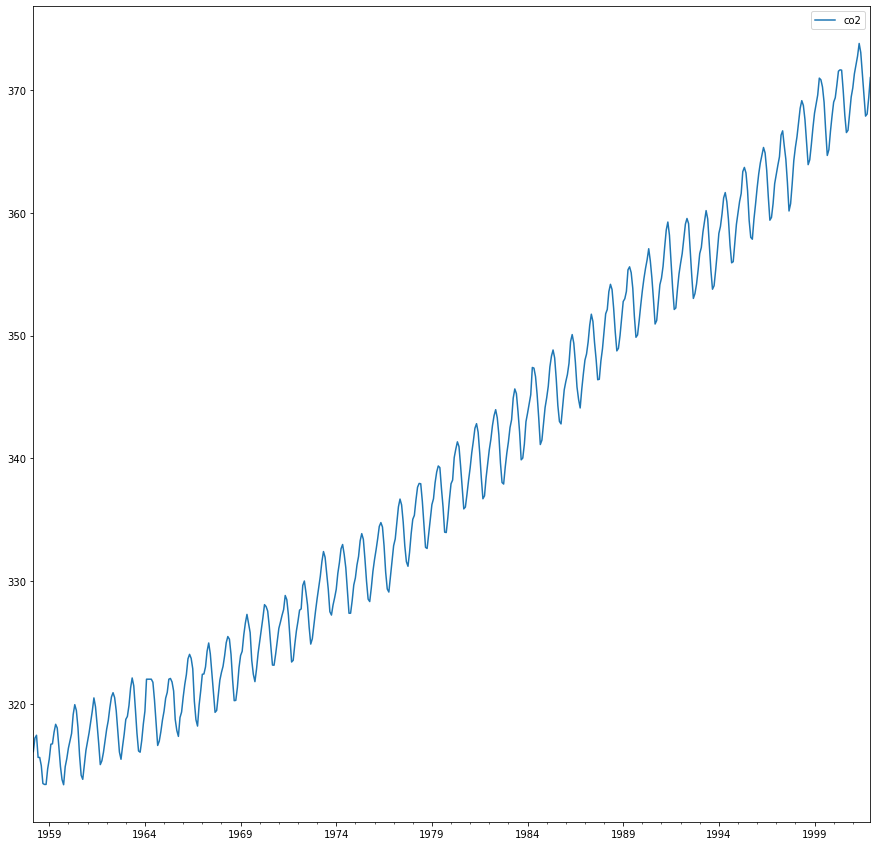

In [13]:
yMonthly.plot(figsize=(15, 15))
plt.show()

In [10]:
decomposition = sm.tsa.seasonal_decompose(yMonthly, model='additive')

### Decomposing the Time Series

In [11]:
type(decomposition)

statsmodels.tsa.seasonal.DecomposeResult

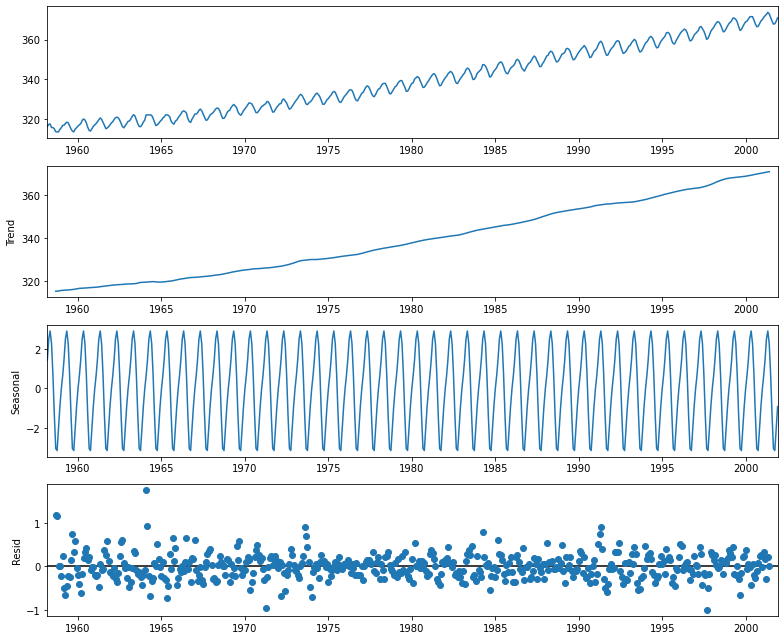

In [12]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(yMonthly, model='additive')
fig = decomposition.plot()
plt.show()

### Stationarity Tests

#### Augmented Dickey Fuller Test - ADF

In [13]:
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [14]:
#apply adf test on the series
adf_test(yMonthly)

Test Statistic            2.359810
p-value                   0.998990
# Lags                   14.000000
# Observations          511.000000
Critical Value (1%)      -3.443212
Critical Value (5%)      -2.867213
Critical Value (10%)     -2.569791
dtype: float64
 Series is Non-Stationary


#### Kwiatkowski Phillips Schmidt Shin - KPSS

In [15]:
def kpss_test(ts, signif=0.05):
    dftest = kpss(ts, regression='ct')
    adf = pd.Series(dftest[0:3], index=['Test Statistic','p-value','# Lags'])
    
    for key,value in dftest[3].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p > signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")

In [16]:
kpss_test(yMonthly)

Test Statistic            0.579607
p-value                   0.010000
# Lags                   19.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
 Series is Non-Stationary


D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### Differencing a time series

### Auto correlation plots

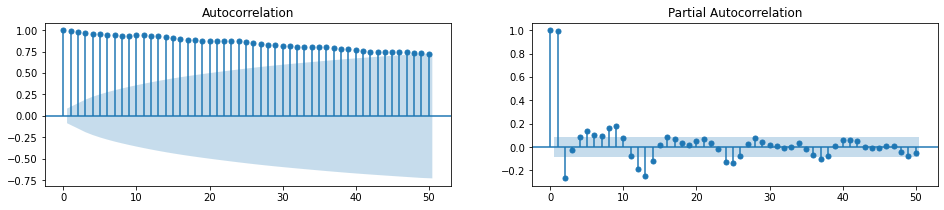

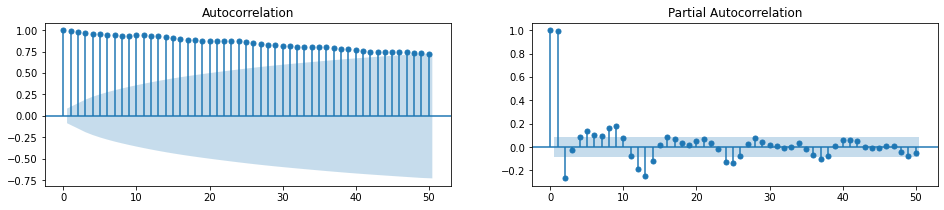

In [25]:
fig, axes = plt.subplots(1,2,figsize=(16,3))
plot_acf(yMonthly.co2.tolist(), lags=50, ax=axes[0])
plot_pacf(yMonthly.co2.tolist(), lags=50, ax=axes[1])

### Finding p (AR Term) q (MA Term) and d (Differencing)

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


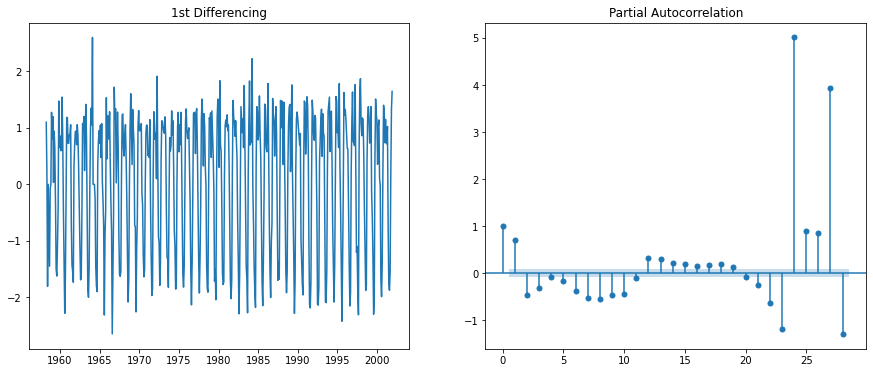

In [33]:
plt.rcParams.update({'figure.figsize':(15,6)})

fig, axes = plt.subplots(1, 2)
axes[0].plot(yMonthly.co2.diff())
axes[0].set_title('1st Differencing')
axes[1].set()
plot_pacf(yMonthly.co2.diff().dropna(), ax=axes[1])

plt.show()

### Finding MA Term (q)

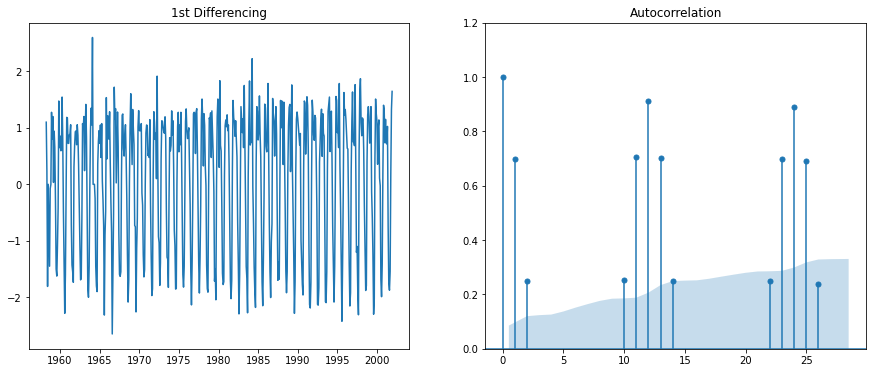

In [35]:
plt.rcParams.update({'figure.figsize':(15,6)})

fig, axes = plt.subplots(1, 2)
axes[0].plot(yMonthly.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(yMonthly.diff().dropna(), ax=axes[1])

plt.show()

### ARIMA

In [42]:
# 1,1,2 ARIMA Model
model = ARIMA(yMonthly, order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    co2   No. Observations:                  526
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -607.411
Date:                Tue, 13 Apr 2021   AIC                           1222.822
Time:                        15:50:42   BIC                           1239.876
Sample:                    03-01-1958   HQIC                          1229.500
                         - 12-01-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4018      0.073      5.529      0.000       0.259       0.544
ma.L1          0.5221      0.072      7.241      0.000       0.381       0.663
ma.L2          0.3636      0.057      6.379      0.0

### Residuals

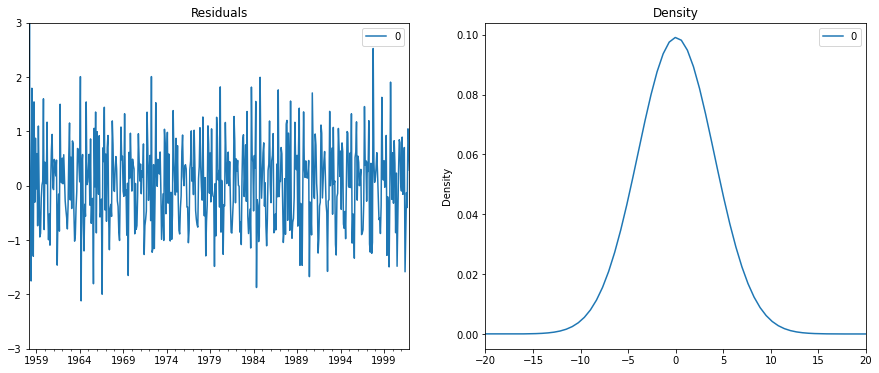

In [52]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
ax[0].set(ylim=(-3,3))
ax[1].set(xlim=(-20,20))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Model Diagnostics

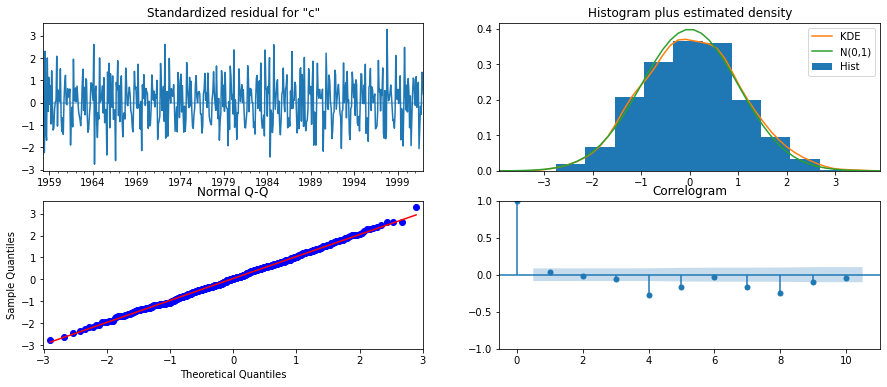

In [55]:
# model_fit.plot_predict(dynamic=False)

model_fit.plot_diagnostics()
plt.show()

### Play with forecasting

In [9]:
train = yMonthly.co2[:450]
test = yMonthly.co2[450:]

In [65]:
model = None
model = ARIMA(train, order=(1, 1, 2))  
fitted = model.fit()

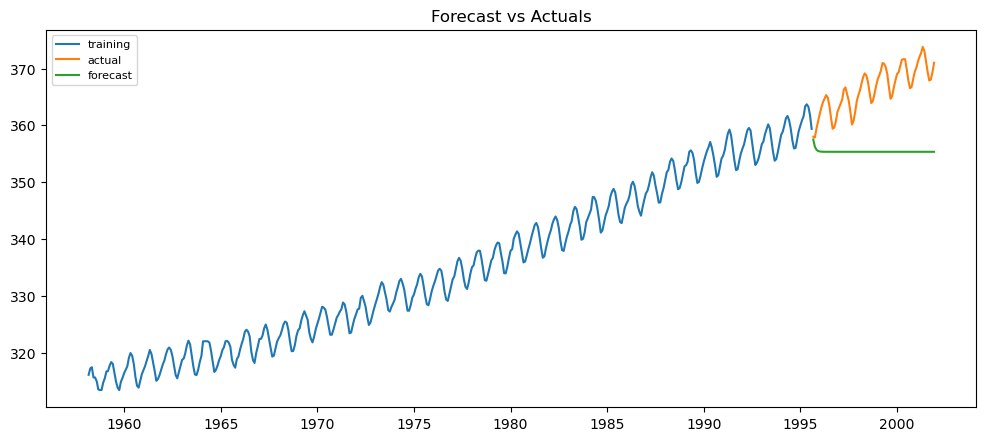

In [81]:
# Forecast
fc = fitted.forecast(76, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Metrics

In [79]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

In [82]:
forecast_accuracy(fc, test.values)

<ipython-input-79-54579e98b1d2>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
<ipython-input-79-54579e98b1d2>:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],
D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.1

{'mape': 0.03013726237955926,
 'me': -11.084639840388855,
 'mae': 11.084639840388855,
 'mpe': -0.03013726237955926,
 'rmse': 11.76429076660587,
 'acf1': 0.8921888901451744,
 'corr': -0.38088401325247717,
 'minmax': 0.030137262379559382}

### Above was manual

### Auto ARIMA

##### https://pypi.org/project/pyramid-arima/

##### https://pypi.org/project/pmdarima/

In [89]:
model = None
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1086.163, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1427.684, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1131.425, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1177.579, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1428.664, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=862.819, Time=0.28 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1035.934, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=860.049, Time=0.37 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=981.827, Time=0.09 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=861.659, Time=0.58 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=857.822, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1042.048, Time=0.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=999.332, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1023.975, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : A

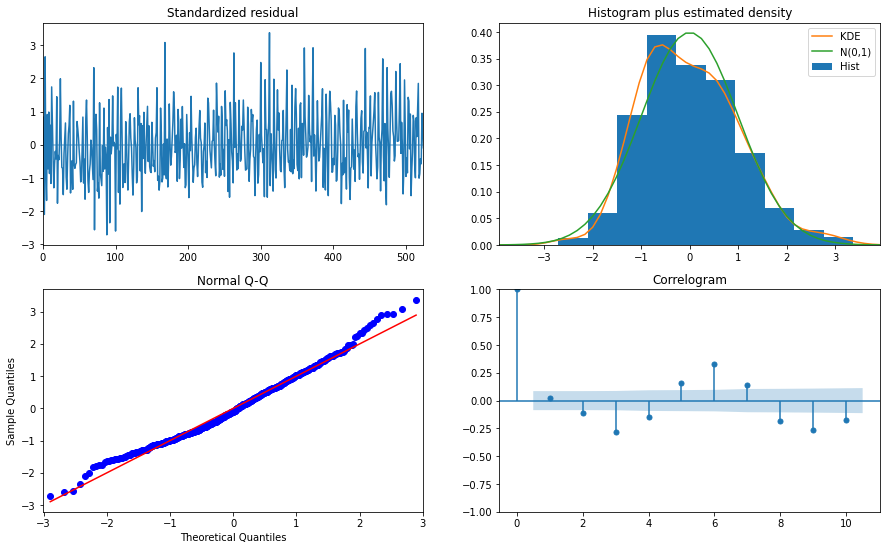

In [88]:
model.plot_diagnostics(figsize=(15,9))
plt.show()

In [91]:
fitted = None

fitted = model.fit(train)

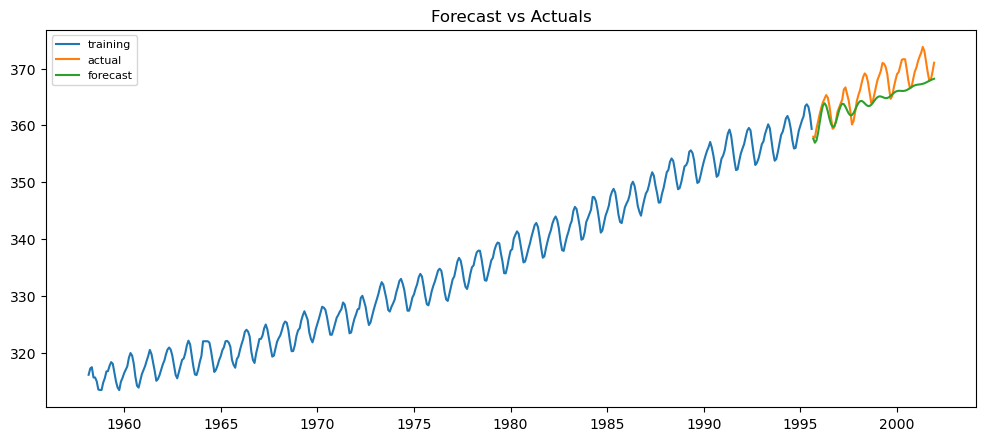

In [95]:
# Forecast
fc = fitted.predict(76)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### ARIMA cant do Seasonal TS

### SARIMA model

In [8]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(yMonthly, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=353.247, Time=1.89 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1091.276, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=496.387, Time=0.71 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=814.185, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1857.624, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=567.816, Time=0.21 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=355.155, Time=1.82 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=355.081, Time=3.24 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=469.234, Time=0.88 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=355.403, Time=3.79 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=346.796, Time=1.79 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=568.141, Time=0.30 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  526
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 12)   Log Likelihood                -164.835
Date:                              Wed, 14 Apr 2021   AIC                            343.670
Time:                                      09:55:55   BIC                            373.365
Sample:                                           0   HQIC                           355.308
                                              - 526                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0058      0.005      1.174      0.241      -0.004       0.016
ar.L1          0.9953      0.004    239.537      0.000       0.987       1.003
ma.L1         -0.2979      0.041     -7.197      0.000      -0.379      -0.217
ma.L2         -0.0875      0.039     -2.253      0.024      -0.164      -0.011
ma.L3         -0.1049      0.040     -2.591      0.010      -0.184      -0.026
ma.S.L12      -0.8668      0.028    -30.518      0.000      -0.923      -0.811
sigma2         0.1070      0.005     20.615      0.000       0.097       0.117
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                96.13
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

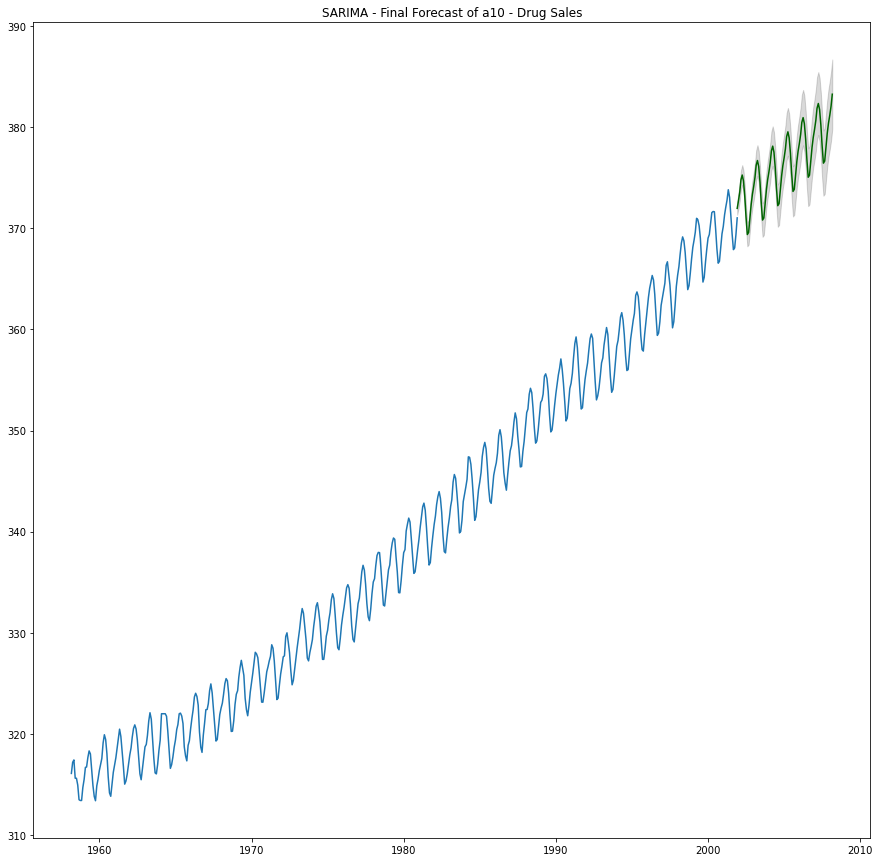

In [12]:
# Forecast
n_periods = 76
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(yMonthly.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,15))
plt.plot(yMonthly)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

### SARIMA Train/Test

In [14]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=321.810, Time=1.38 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=890.044, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=437.221, Time=0.62 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=673.258, Time=0.95 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1538.265, Time=0.03 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=491.689, Time=0.16 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=418.911, Time=0.77 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=3.10 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=350.500, Time=0.97 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=311.297, Time=1.69 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=490.296, Time=0.40 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AIC=315.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  450
Model:             SARIMAX(2, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -150.588
Date:                            Wed, 14 Apr 2021   AIC                            311.176
Time:                                    10:00:09   BIC                            331.587
Sample:                                         0   HQIC                           319.230
                                            - 450                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4288      0.085     16.876      0.000       1.263       1.595
ar.L2         -0.4289      0.085     -5.068      0.000      -0.595      -0.263
ma.L1         -0.7412      0.067    -11.119      0.000      -0.872      -0.611
ma.S.L12      -0.8621      0.032    -27.307      0.000      -0.924      -0.800
sigma2         0.1116      0.006     19.846      0.000       0.101       0.123
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               130.21
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

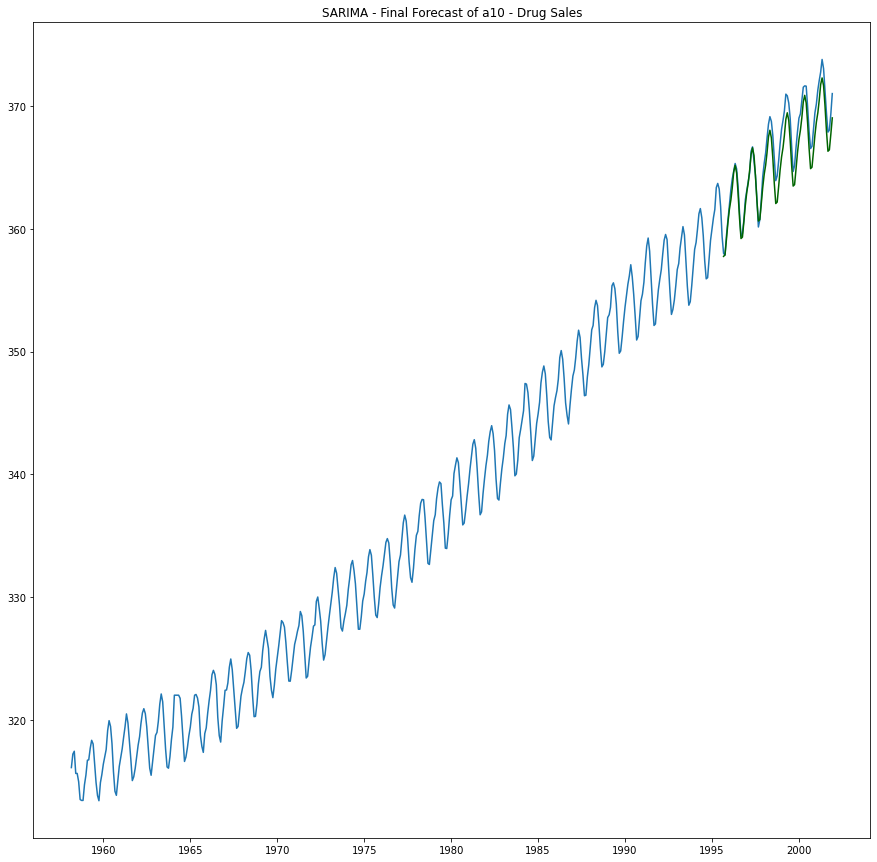

In [40]:
# Forecast
n_periods = 76
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(test.index[0], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,15))
plt.plot(yMonthly)
plt.plot(fitted_series, color='darkgreen')

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

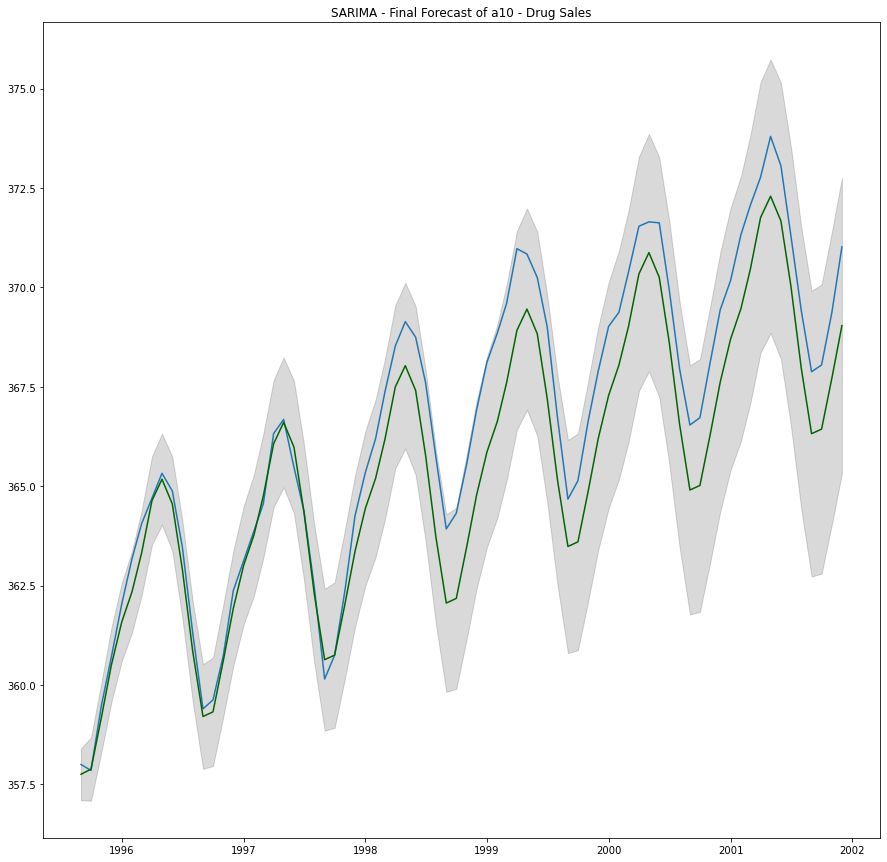

In [41]:
# Forecast
n_periods = 76
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(test.index[0], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(15,15))
plt.plot(test)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()